# **Corn or Maize Leaf Disease Classification**

**In this Notebook, We have to predict Corn or Maize Leaf Disease Classification. For This Purpose, We used Pretrained Models called Transfer Learning. Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.**

**Dataset we are Using  https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset**

**We used two Different Pretrained Deep learning Models to get maximum accuracy and minumum loss**

**This Notebook is Designed in Google Colab and Using GPU Runtime Type**

## **1-Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **2-Load Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-15 08:15:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 08:15:04 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **3-Import Functions Using Helper Functions**

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## **4-Install and Import Split Folders**

In [4]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

## **5-Mount Data From Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **6-Load Data from Google Drive**

In [7]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/corn-or-maize-leaf-disease-dataset (2).zip")
zip_ref.extractall()
zip_ref.close()

## **7-Get Class Names Programmatically**

In [8]:
# get the class names prgrammatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/corn-or-maize-leaf-disease-dataset/balanced_dataset")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subdirectories
print(class_names)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


## **8-Visualize Our Images**

In [9]:
# let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # this line means randomly sample one item form the target folder
  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show thw shape of the image

  return img 

## **9-Split The Folders into Train , Validation and Test Datasets**

In [10]:
splitfolders.ratio("/content/corn-or-maize-leaf-disease-dataset/balanced_dataset", output="corn-or-maize-dataset-split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 2296 files [00:00, 4066.79 files/s]


## **10-Set Train, Test and Validation Paths**

In [11]:
train_dir = "/content/corn-or-maize-dataset-split/train/"
test_dir = "/content/corn-or-maize-dataset-split/test/"
val_dir = '/content/corn-or-maize-dataset-split/val/'

## **11-Checking Number of Images**

In [12]:
# How many images/classes are there?
walk_through_dir("/content/corn-or-maize-leaf-disease-dataset/balanced_dataset")

There are 4 directories and 0 images in '/content/corn-or-maize-leaf-disease-dataset/balanced_dataset'.
There are 0 directories and 574 images in '/content/corn-or-maize-leaf-disease-dataset/balanced_dataset/Healthy'.
There are 0 directories and 574 images in '/content/corn-or-maize-leaf-disease-dataset/balanced_dataset/Common_Rust'.
There are 0 directories and 574 images in '/content/corn-or-maize-leaf-disease-dataset/balanced_dataset/Blight'.
There are 0 directories and 574 images in '/content/corn-or-maize-leaf-disease-dataset/balanced_dataset/Gray_Leaf_Spot'.


## **12-Set Data Inputs**

In [13]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 1836 files belonging to 4 classes.
Found 232 files belonging to 4 classes.


## **13-Create Checkpoint Callback**

In [14]:

# Create a checkpoint callback
checkpoint_path = "corn-or-maize-disease-dataset-model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## **14-Make Data Augmentation**

In [15]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")


# **Model No 1 EfficientNet V2B3**

## **15-Setup Base Model (Feature Extraction)**

In [16]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(inputs, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

52617216/52606240 [==============================] - 0s 0us/step


In [17]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_avg_pooling_layer (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 4)                 6148      
                                                                 
Total params: 12,936,770
Trainable params: 6,148
Non-trainable params: 12,930,622
_________________________________________________________________


## **16-Import Metrics**

In [18]:
from tensorflow.keras import metrics

In [19]:
METRICS = [
  metrics.TruePositives(name="tp"),
  metrics.FalsePositives(name="fp"),
  metrics.TrueNegatives(name="tn"),
  metrics.FalseNegatives(name="fn"),
  metrics.CategoricalAccuracy(name="accuracy"),
  metrics.Precision(name="precision"),
  metrics.Recall(name="recall"),
  metrics.AUC(name="auc")
]

## **17-Compile and Fit The Model**

In [20]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_for_feature_extraction = model.fit(train_data,
                                           epochs=5, # fit to 5 epochs to keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training 
                                           callbacks=[checkpoint_callback])

Epoch 1/5
58/58 [==============================] - 41s 188ms/step - loss: 0.6697 - tp: 1061.0000 - fp: 131.0000 - tn: 5377.0000 - fn: 775.0000 - accuracy: 0.7489 - precision: 0.8901 - recall: 0.5779 - auc: 0.9375 - val_loss: 0.5646 - val_tp: 26.0000 - val_fp: 3.0000 - val_tn: 93.0000 - val_fn: 6.0000 - val_accuracy: 0.8750 - val_precision: 0.8966 - val_recall: 0.8125 - val_auc: 0.9575
Epoch 2/5
58/58 [==============================] - 8s 139ms/step - loss: 0.3460 - tp: 1547.0000 - fp: 135.0000 - tn: 5373.0000 - fn: 289.0000 - accuracy: 0.8818 - precision: 0.9197 - recall: 0.8426 - auc: 0.9840 - val_loss: 0.3694 - val_tp: 28.0000 - val_fp: 3.0000 - val_tn: 93.0000 - val_fn: 4.0000 - val_accuracy: 0.9062 - val_precision: 0.9032 - val_recall: 0.8750 - val_auc: 0.9844
Epoch 3/5
58/58 [==============================] - 7s 119ms/step - loss: 0.2795 - tp: 1624.0000 - fp: 123.0000 - tn: 5385.0000 - fn: 212.0000 - accuracy: 0.9069 - precision: 0.9296 - recall: 0.8845 - auc: 0.9893 - val_loss: 0

## **18-Evaluate The Model**

In [21]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

8/8 [==============================] - 1s 178ms/step - loss: 0.1769 - tp: 220.0000 - fp: 7.0000 - tn: 689.0000 - fn: 12.0000 - accuracy: 0.9569 - precision: 0.9692 - recall: 0.9483 - auc: 0.9970


[0.17694979906082153,
 220.0,
 7.0,
 689.0,
 12.0,
 0.9568965435028076,
 0.9691630005836487,
 0.9482758641242981,
 0.9970459938049316]

## **19-Plot The Graph**

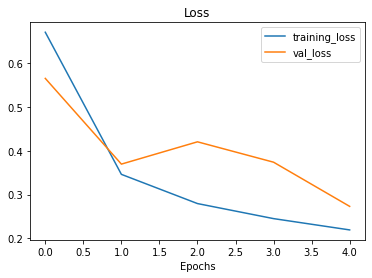

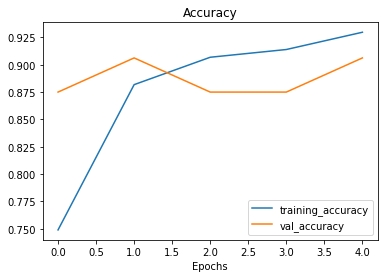

In [22]:
plot_loss_curves(history_for_feature_extraction)

## **20-Unfreeze Some Layers**

In [23]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

## **21-Recompile and Fit The Model**

In [24]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [25]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b3 True
global_avg_pooling_layer True
output_layer True


In [26]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_add False
13 block2a_expand_conv False
14 block2a_expand_bn False
15 block2a_expand_activation False
16 block2a_project_conv False
17 block2a_project_bn False
18 block2b_expand_conv False
19 block2b_expand_bn False
20 block2b_expand_activation False
21 block2b_project_conv False
22 block2b_project_bn False
23 block2b_add False
24 block2c_expand_conv False
25 block2c_expand_bn False
26 block2c_expand_activation False
27 block2c_project_conv False
28 block2c_project_bn False
29 block2c_add False
30 block3a_expand_conv False
31 block3a_expand_bn False
32 block3a_expand_activation False
33 block3a_project_conv False
34 block3a_project_bn False
35 block3b_expand_conv False
36 block3b_exp

In [27]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_for_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_for_feature_extraction.epoch[-1])

Epoch 5/10
58/58 [==============================] - 21s 182ms/step - loss: 0.1997 - tp: 1910.0000 - fp: 110.0000 - tn: 6094.0000 - fn: 158.0000 - accuracy: 0.9376 - precision: 0.9455 - recall: 0.9236 - auc: 0.9943 - val_loss: 0.3301 - val_tp: 29.0000 - val_fp: 3.0000 - val_tn: 93.0000 - val_fn: 3.0000 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062 - val_auc: 0.9810
Epoch 6/10
58/58 [==============================] - 8s 124ms/step - loss: 0.1706 - tp: 1711.0000 - fp: 90.0000 - tn: 5418.0000 - fn: 125.0000 - accuracy: 0.9412 - precision: 0.9500 - recall: 0.9319 - auc: 0.9957 - val_loss: 0.2525 - val_tp: 30.0000 - val_fp: 2.0000 - val_tn: 94.0000 - val_fn: 2.0000 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9906
Epoch 7/10
58/58 [==============================] - 7s 123ms/step - loss: 0.1472 - tp: 1736.0000 - fp: 76.0000 - tn: 5432.0000 - fn: 100.0000 - accuracy: 0.9537 - precision: 0.9581 - recall: 0.9455 - auc: 0.9969 - val_loss: 

## **22-Re_Evaluate The Model**

In [28]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

8/8 [==============================] - 1s 118ms/step - loss: 0.1140 - tp: 224.0000 - fp: 7.0000 - tn: 689.0000 - fn: 8.0000 - accuracy: 0.9655 - precision: 0.9697 - recall: 0.9655 - auc: 0.9984


[0.11403942853212357,
 224.0,
 7.0,
 689.0,
 8.0,
 0.9655172228813171,
 0.9696969985961914,
 0.9655172228813171,
 0.9983804225921631]

## **23-Compare Histories**

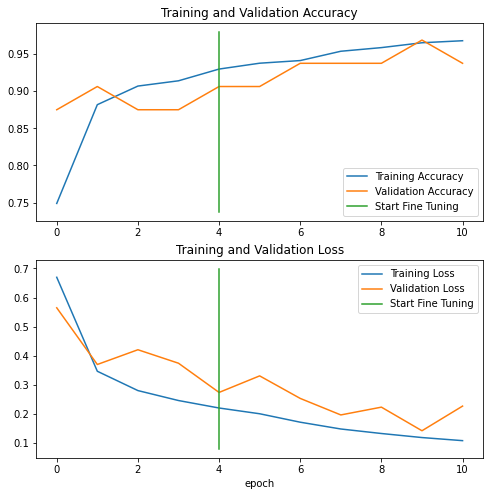

In [29]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_for_feature_extraction,
                 new_history=history_for_fine_tune,
                 initial_epochs=5)

## **24-Save The Model**

In [30]:
# Save our fine-tuning model
model.save("corn-or-maize-leaf-model.h5")
model.save("corn-or-maize-leaf-model.hdf5")

## **26-Make Prediction Probabilites**

In [34]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

8/8 [==============================] - 3s 128ms/step


In [35]:
len(test_data)

8

In [36]:
# How many predictions are there?
len(preds_probs)

232

In [37]:
# What's the shape of our predictions?
preds_probs.shape

(232, 4)

In [38]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[6.8684304e-01, 6.0789060e-02, 2.5087541e-01, 1.4924821e-03],
       [9.3977726e-01, 1.6788630e-03, 5.8524404e-02, 1.9446699e-05],
       [9.0393925e-01, 9.8118670e-03, 8.1733346e-02, 4.5155152e-03],
       [9.8427355e-01, 8.9026109e-04, 1.4813614e-02, 2.2608190e-05],
       [9.3496406e-01, 5.9055117e-05, 6.4963147e-02, 1.3761132e-05],
       [7.2537094e-01, 1.9993656e-03, 2.7257553e-01, 5.4135166e-05],
       [9.7174406e-01, 8.3288336e-07, 2.8254962e-02, 9.4631076e-08],
       [7.8735894e-01, 3.9426163e-03, 2.0842887e-01, 2.6959908e-04],
       [7.7056450e-01, 1.1389566e-03, 2.2827837e-01, 1.8195495e-05],
       [6.9635439e-01, 4.4325409e-03, 2.9918507e-01, 2.8025222e-05]],
      dtype=float32)

In [39]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([0.68684304, 0.06078906, 0.2508754 , 0.00149248], dtype=float32),
 4,
 0.9999999930150807)

In [40]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 4
What prediction probabilites sample 0 looks like:
 [0.68684304 0.06078906 0.2508754  0.00149248]
The class with highest predicted probability by the model for sample 0: 0


In [41]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
# How many pred classes we have?
len(pred_classes)

232

In [43]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
# How many y_labels are there?
len(y_labels)

232

In [45]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [46]:
len(test_data)

8

## **27-Make Confusion Matrix**

In [47]:
from helper_functions import make_confusion_matrix

In [48]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [49]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

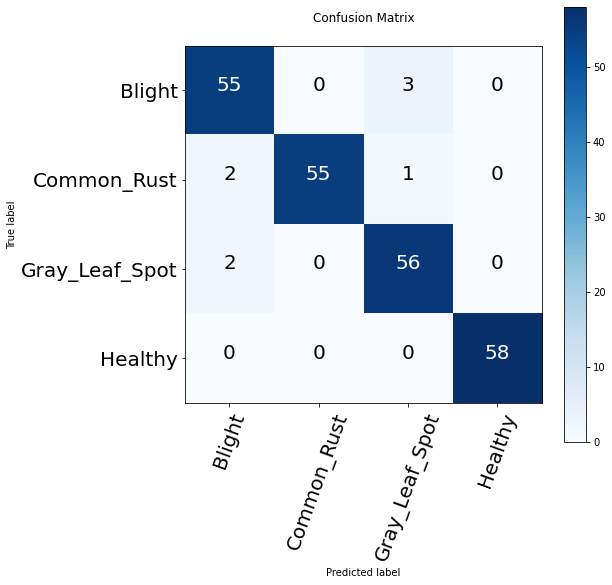

In [50]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(8, 8),
                      text_size=20,
                      savefig=True)

## **28-Make Classification Report**

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        58
           1       1.00      0.95      0.97        58
           2       0.93      0.97      0.95        58
           3       1.00      1.00      1.00        58

    accuracy                           0.97       232
   macro avg       0.97      0.97      0.97       232
weighted avg       0.97      0.97      0.97       232



In [52]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.94017094017094,
  'precision': 0.9322033898305084,
  'recall': 0.9482758620689655,
  'support': 58},
 '1': {'f1-score': 0.9734513274336283,
  'precision': 1.0,
  'recall': 0.9482758620689655,
  'support': 58},
 '2': {'f1-score': 0.9491525423728815,
  'precision': 0.9333333333333333,
  'recall': 0.9655172413793104,
  'support': 58},
 '3': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 58},
 'accuracy': 0.9655172413793104,
 'macro avg': {'f1-score': 0.9656937024943625,
  'precision': 0.9663841807909604,
  'recall': 0.9655172413793104,
  'support': 232},
 'weighted avg': {'f1-score': 0.9656937024943624,
  'precision': 0.9663841807909604,
  'recall': 0.9655172413793104,
  'support': 232}}

In [53]:
class_names[3]

'Healthy'

In [54]:
classification_report_dict["3"]["f1-score"]

1.0

In [55]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Blight': 0.94017094017094,
 'Common_Rust': 0.9734513274336283,
 'Gray_Leaf_Spot': 0.9491525423728815,
 'Healthy': 1.0}

In [56]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                

,class_names,f1-score
3,Healthy,1.000000
1,Common_Rust,0.973451
2,Gray_Leaf_Spot,0.949153
0,Blight,0.940171


In [57]:
f1_scores[:2]

,class_names,f1-score
3,Healthy,1.000000
1,Common_Rust,0.973451


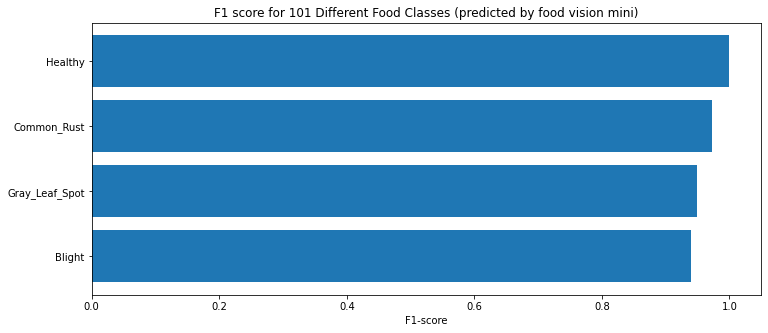

In [58]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

## **29-Load and Prepare Images Function**

In [59]:
# Create a function to load and create a images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turn it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) 

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yes/no?
  if scale:
    # reshape the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale image for EffiecienNet model in TensorFlow   


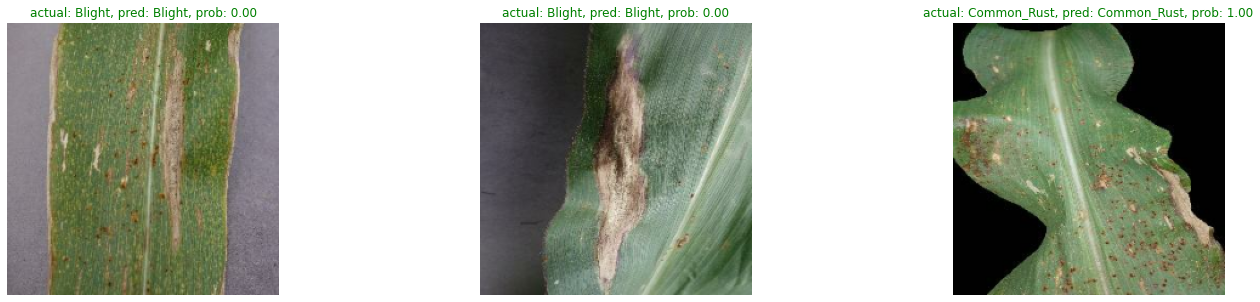

In [60]:
# Make preds on series of images
import os
import random

plt.figure(figsize=(24,5))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name =random.choice(class_names)
  filename = random.choice(os.listdir(val_dir + "/" + class_name))
  filepath = val_dir + class_name + "/" + filename


  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get heighst prediction probability index and match it class_names list
  # print(pred_prob)
   # print(pred_class)

    # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
  plt.axis(False);  

In [61]:
images = ['/content/common-rust.jpg', '/content/grey leaf spot.jpg', '/content/blight.jpg', '/content/corn-leaf-close-up-green-leaves-31836052.jpg']

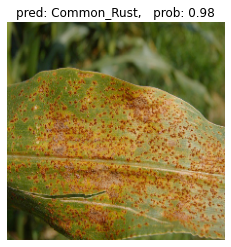

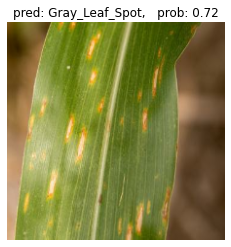

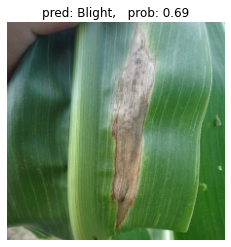

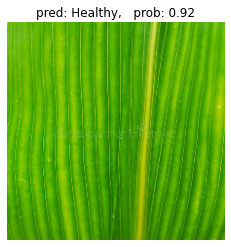

In [62]:
# Make prediction on and plot the custom food images
for img in images:
  img = load_and_prep_image(img, scale=False) # don't need to do scale for our EfficienNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on the image with shape [1, 224,224, 1] (same shape as model trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with heighest prediction probability
  # plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class},   prob: {pred_prob.max():.2f}")
  plt.axis(False)

## **Model For EfficientNetB4**

In [63]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(inputs, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

71696384/71686520 [==============================] - 0s 0us/step


In [64]:
from tensorflow.keras import metrics

In [65]:
METRICS = [
  metrics.TruePositives(name="tp"),
  metrics.FalsePositives(name="fp"),
  metrics.TrueNegatives(name="tn"),
  metrics.FalseNegatives(name="fn"),
  metrics.CategoricalAccuracy(name="accuracy"),
  metrics.Precision(name="precision"),
  metrics.Recall(name="recall"),
  metrics.AUC(name="auc")
]

In [66]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)


In [67]:
# Fit
history_for_feature_extraction = model.fit(train_data,
                                           epochs=5, # fit to 5 epochs to keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training 
                                           callbacks=[checkpoint_callback])

Epoch 1/5
58/58 [==============================] - 27s 242ms/step - loss: 0.6962 - tp: 1033.0000 - fp: 129.0000 - tn: 5379.0000 - fn: 803.0000 - accuracy: 0.7391 - precision: 0.8890 - recall: 0.5626 - auc: 0.9315 - val_loss: 0.5642 - val_tp: 22.0000 - val_fp: 4.0000 - val_tn: 92.0000 - val_fn: 10.0000 - val_accuracy: 0.7812 - val_precision: 0.8462 - val_recall: 0.6875 - val_auc: 0.9692
Epoch 2/5
58/58 [==============================] - 11s 187ms/step - loss: 0.4110 - tp: 1463.0000 - fp: 161.0000 - tn: 5347.0000 - fn: 373.0000 - accuracy: 0.8453 - precision: 0.9009 - recall: 0.7968 - auc: 0.9764 - val_loss: 0.5204 - val_tp: 21.0000 - val_fp: 9.0000 - val_tn: 87.0000 - val_fn: 11.0000 - val_accuracy: 0.7188 - val_precision: 0.7000 - val_recall: 0.6562 - val_auc: 0.9565
Epoch 3/5
58/58 [==============================] - 11s 177ms/step - loss: 0.3381 - tp: 1554.0000 - fp: 142.0000 - tn: 5366.0000 - fn: 282.0000 - accuracy: 0.8851 - precision: 0.9163 - recall: 0.8464 - auc: 0.9843 - val_los

In [68]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results


8/8 [==============================] - 2s 262ms/step - loss: 0.2740 - tp: 204.0000 - fp: 17.0000 - tn: 679.0000 - fn: 28.0000 - accuracy: 0.9052 - precision: 0.9231 - recall: 0.8793 - auc: 0.9898


[0.2739827036857605,
 204.0,
 17.0,
 679.0,
 28.0,
 0.9051724076271057,
 0.9230769276618958,
 0.8793103694915771,
 0.9897661209106445]

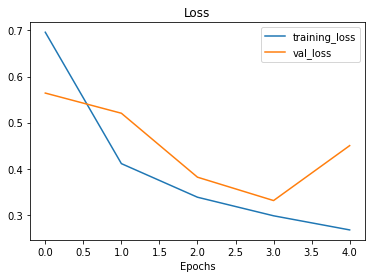

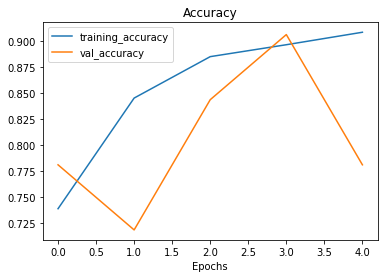

In [69]:
plot_loss_curves(history_for_feature_extraction)


In [70]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [71]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)


# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)



# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable )

input_layer True
efficientnetb4 True
global_avg_pooling_layer True
output_layer True
0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a

In [72]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_for_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_for_feature_extraction.epoch[-1])



Epoch 5/10
58/58 [==============================] - 26s 232ms/step - loss: 0.2486 - tp: 1837.0000 - fp: 143.0000 - tn: 6061.0000 - fn: 231.0000 - accuracy: 0.9120 - precision: 0.9278 - recall: 0.8883 - auc: 0.9909 - val_loss: 0.2849 - val_tp: 29.0000 - val_fp: 3.0000 - val_tn: 93.0000 - val_fn: 3.0000 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062 - val_auc: 0.9922
Epoch 6/10
58/58 [==============================] - 11s 178ms/step - loss: 0.2069 - tp: 1665.0000 - fp: 111.0000 - tn: 5397.0000 - fn: 171.0000 - accuracy: 0.9232 - precision: 0.9375 - recall: 0.9069 - auc: 0.9941 - val_loss: 0.2246 - val_tp: 30.0000 - val_fp: 2.0000 - val_tn: 94.0000 - val_fn: 2.0000 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9969
Epoch 7/10
58/58 [==============================] - 11s 180ms/step - loss: 0.1834 - tp: 1698.0000 - fp: 92.0000 - tn: 5416.0000 - fn: 138.0000 - accuracy: 0.9341 - precision: 0.9486 - recall: 0.9248 - auc: 0.9954 - val_los

In [73]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

8/8 [==============================] - 1s 168ms/step - loss: 0.1935 - tp: 217.0000 - fp: 14.0000 - tn: 682.0000 - fn: 15.0000 - accuracy: 0.9353 - precision: 0.9394 - recall: 0.9353 - auc: 0.9938


[0.19352512061595917,
 217.0,
 14.0,
 682.0,
 15.0,
 0.9353448152542114,
 0.939393937587738,
 0.9353448152542114,
 0.9937666058540344]

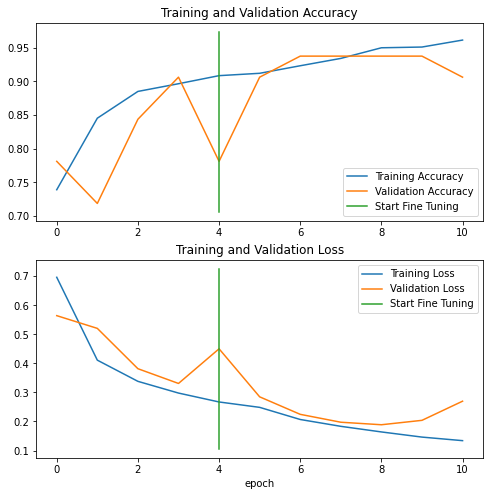

In [74]:
compare_historys(history_for_feature_extraction,
                 history_for_fine_tune)

In [75]:
model.save("corn-maize-b4-model.h5")
model.save("corn-maize-b4-model.hdf5")

In [76]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left


len(test_data)


# How many predictions are there?
len(preds_probs)


# What's the shape of our predictions?
preds_probs.shape


# Let's see whats the first 10 predictions looks like
preds_probs[:10]



# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])



# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")




# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]




# How many pred classes we have?
len(pred_classes)




# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 



# How many y_labels are there?
len(y_labels)


test_data


len(test_data)

8/8 [==============================] - 4s 176ms/step
Number of prediction probabilites for sample 0: 4
What prediction probabilites sample 0 looks like:
 [0.6883736  0.02707887 0.28179568 0.00275171]
The class with highest predicted probability by the model for sample 0: 0


8

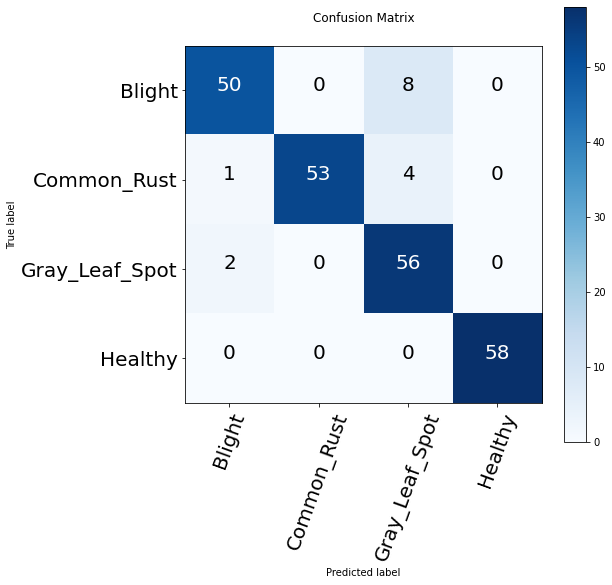

In [77]:
from helper_functions import make_confusion_matrix



# Get a list of class names
class_names =test_data.class_names
class_names[:10]



import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")



make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(8, 8),
                      text_size=20,
                      savefig=True)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))



# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict



classification_report_dict["3"]["f1-score"]


              precision    recall  f1-score   support

           0       0.94      0.86      0.90        58
           1       1.00      0.91      0.95        58
           2       0.82      0.97      0.89        58
           3       1.00      1.00      1.00        58

    accuracy                           0.94       232
   macro avg       0.94      0.94      0.94       232
weighted avg       0.94      0.94      0.94       232



1.0

In [79]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     




# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                

,class_names,f1-score
3,Healthy,1.000000
1,Common_Rust,0.954955
0,Blight,0.900901
2,Gray_Leaf_Spot,0.888889


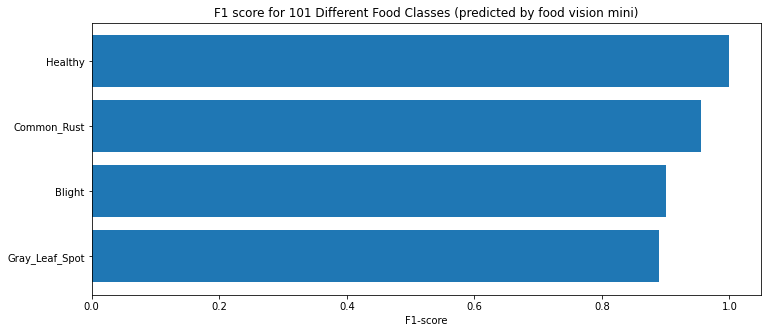

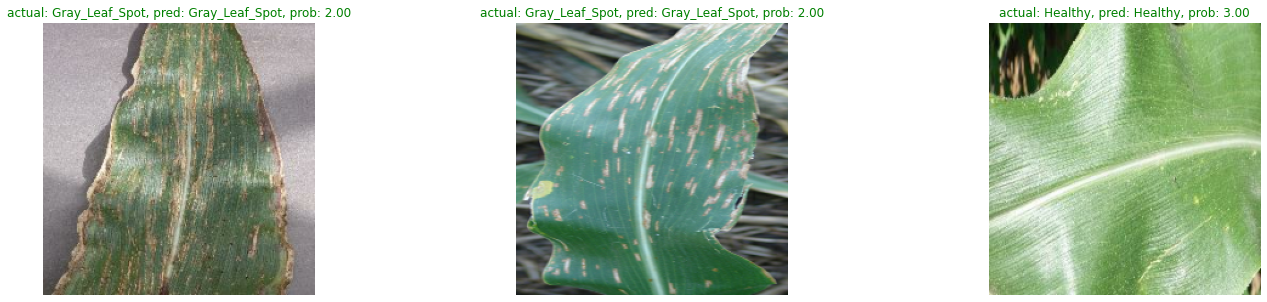

In [80]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 






# Create a function to load and create a images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turn it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) 

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yes/no?
  if scale:
    # reshape the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale image for EffiecienNet model in TensorFlow   







# Make preds on series of images
import os
import random

plt.figure(figsize=(24,5))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name =random.choice(class_names)
  filename = random.choice(os.listdir(val_dir + "/" + class_name))
  filepath = val_dir + class_name + "/" + filename


  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get heighst prediction probability index and match it class_names list
  # print(pred_prob)
   # print(pred_class)

    # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
  plt.axis(False);  

In [81]:
images = ['/content/common-rust.jpg', '/content/grey leaf spot.jpg', '/content/blight.jpg', '/content/corn-leaf-close-up-green-leaves-31836052.jpg']

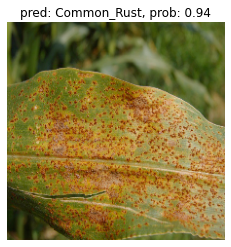

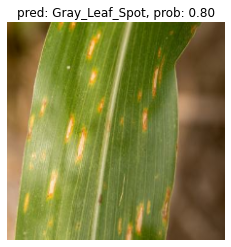

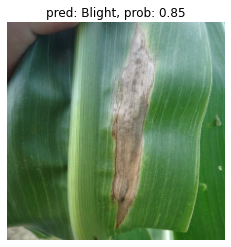

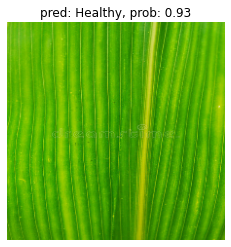

In [82]:
# Make prediction on and plot the custom food images
for img in images:
  img = load_and_prep_image(img, scale=False) # don't need to do scale for our EfficienNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on the image with shape [1, 224,224, 1] (same shape as model trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with heighest prediction probability
  # plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)